# ORB Feature Extractor on FPGA
ORB feature is a kind of image feature based on oriented FAST feature and BRIEF descriptor. It's used in feature mapping of some famous work such as ORB-SLAM.   
The extractor will take a gray image and applys a FAST extractor on it. After feature points being found, it will calculate m01 and m10 moment of the feature points and figure out the angle of them. Calculating BRIEF descriptors needs the angle and a gray image which is the original gray image applied a 7x7 gaussian filter.   
![Accelerator](./data/accel.jpg)
So we designed 2 input stream ports taking same image：the first one transfer the image to find out oFAST feature and the second one go through a gaussian filter, and finnally they will go into BRIEF descriptor computing module. 

## 1. Testing on one picture  

### 1. Importing and initializing
![System](./data/sys.jpg)
2 input stream ports needs 2 DMA to send data, and 1 output stream port needs 1 DMA to reciecve data. We need to initialize these DMA and start their corresponding channels. 

In [1]:
from pynq import Overlay
from pynq import Xlnk
import matplotlib.pyplot as plt
import numpy as np
import cv2
from time import time
xlnk = Xlnk()
overlay = Overlay('/usr/local/lib/python3.6/dist-packages/ORB_FPGA/overlays/ORB_FPGA.bit')
dma_FAST = overlay.axi_dma_FAST
dma_Gaus = overlay.axi_dma_Gaus
dma_des = overlay.axi_dma_des_2Mem
dma_des.recvchannel.start()
dma_FAST.sendchannel.start()
dma_Gaus.sendchannel.start()

### 2. Reading image
We read image with opencv and copy it to the buffer ready to be transffered. Also a buffer for recieving should be ready.

In [2]:
img_ori = cv2.imread('./test_data/'+'0'+'.jpg')
img_gray = cv2.cvtColor(img_ori,cv2.COLOR_BGR2GRAY)
src_buf = xlnk.cma_array(shape=(640*480,), dtype=np.uint8)
view=np.frombuffer(src_buf,dtype = np.uint8,count = -1)
np.copyto(view,img_gray.ravel(),casting='same_kind')
des_buf = xlnk.cma_array(shape=(8192,10), dtype=np.int32)

### 3. Doing the process on FPGA
Transfer data with these DMA channels and wait. 

In [3]:
dma_des.recvchannel.transfer(des_buf)
dma_FAST.sendchannel.transfer(src_buf)
dma_Gaus.sendchannel.transfer(src_buf)
dma_Gaus.sendchannel.wait()
dma_FAST.sendchannel.wait()
dma_des.recvchannel.wait()
des_buf.flush()
bytes_read=dma_des.mmio.read(0x58)
featurePointsNum = int(bytes_read/40) - 1
print(str(featurePointsNum)+' feature points are detected')

1914 feature points are detected


Here we print first 2 group of the data we have recieved. One feature points is descirbed with 10 int32 numbers. Element 0~7 is a 256 bit BRIEF descriptor, which can be used for feature matching. Element 8 is x positon and 9 is y position( in opencv definition ).

In [4]:
for i in range(2):
    posX = des_buf[i][8]
    posY = des_buf[i][9]
    print('descriptor: ')
    print(des_buf[i][0:7])
    print('\npositon:')
    print('x:'+str(posX)+'  y:'+str(posY)+'\n')

descriptor: 
[ 1078211195   407379757  1287022819 -1265204917   217875468 -1862835315
 -1165887086]

positon:
x:625  y:3

descriptor: 
[ 1951675001   407412525  1823910115 -1227697717   217900046 -2130746483
 -1306395758]

positon:
x:623  y:4



### 3. Drawing feature points on image 

In [5]:
points = des_buf[0:(featurePointsNum-1)]
pos = (points[:,8:10]).copy()
posList=pos.tolist()
for i in posList:
    cv2.circle(img_ori,(i[0],i[1]),2,(0, 0, 213),-1)

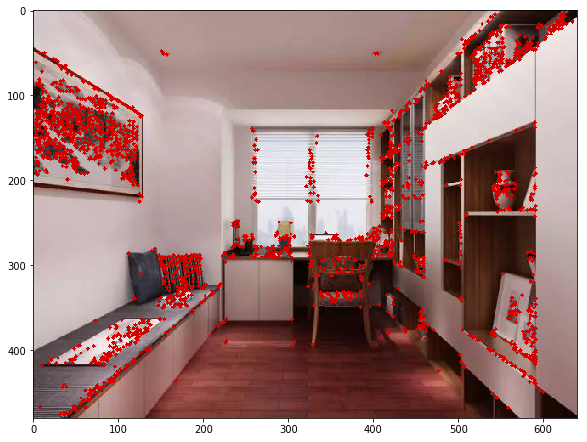

In [6]:
img_disp = cv2.cvtColor(img_ori,cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,7.5))
plt.imshow(img_disp)

### 4. Do not forget free all the buffer 

In [7]:
src_buf.freebuffer()
des_buf.freebuffer()

## 2. Testing on multiple images
### 1. Reading 20 testing images  

In [8]:
img_list = []
for i in range (20):
    img_gray = cv2.imread('./test_data/'+str(i)+'.jpg',cv2.IMREAD_GRAYSCALE)
    src_buf = xlnk.cma_array(shape=(640*480,), dtype=np.uint8)
    view=np.frombuffer(src_buf,dtype = np.uint8,count = -1)
    np.copyto(view,img_gray.ravel(),casting='same_kind')
    img_list.append(src_buf)
des_buf = xlnk.cma_array(shape=(8192,10), dtype=np.int32)

### 2. Processing them on FPGA

In [9]:
start = time()
for src_buf in img_list:
    dma_des.recvchannel.transfer(des_buf)
    dma_FAST.sendchannel.transfer(src_buf)
    dma_Gaus.sendchannel.transfer(src_buf)
    dma_Gaus.sendchannel.wait()
    dma_FAST.sendchannel.wait()
    dma_des.recvchannel.wait()
    des_buf.flush()
    src_buf.freebuffer()
stop = time()
print(str((stop-start)/20) + " seconds per picture")
print(str(1/((stop-start)/20)) + " FPS")

0.01756783723831177 seconds per picture
56.92220313945132 FPS


### 3. Stop the DMA

In [10]:
dma_des.recvchannel.stop()
dma_FAST.sendchannel.stop()
dma_Gaus.sendchannel.stop()